<a href="https://colab.research.google.com/github/surya81/Encoder-Decoder-Model/blob/main/similar_imge_grouping_using_t_sne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize([0.5], [0.5]),
  transforms.Lambda(lambda x: x.to(device))
  ])
trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)
batch_size = 128
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

     |████████████████████████████████| 49 kB 3.0 MB/s 
     |████████████████████████████████| 78 kB 4.5 MB/s 
     |████████████████████████████████| 235 kB 37.8 MB/s 
     |████████████████████████████████| 948 kB 63.4 MB/s 
     |████████████████████████████████| 58 kB 7.2 MB/s 
     |████████████████████████████████| 51 kB 8.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [2]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder= nn.Sequential(
        nn.Conv2d(1,32,3,stride = 3,padding = 1),
        nn.ReLU(True),
        nn.MaxPool2d(2,stride = 2),
        nn.Conv2d(32,64,3,stride = 2,padding = 1),
        nn.ReLU(True),
        nn.MaxPool2d(2,stride =1)

    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64,32,3,stride = 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(32,16,5,stride = 3,padding = 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(16,1 ,2,stride = 2,padding = 1),
        nn.Tanh()
        )

  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x 

In [3]:
model = AutoEncoder().to(device)

In [4]:
latent_vectors = []
classes = []

In [5]:
for im,clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im),-1))
    classes.extend(clss)

In [6]:
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

In [7]:
from sklearn.manifold import TSNE
tsne = TSNE(2)

In [8]:
clustered = tsne.fit_transform(latent_vectors)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


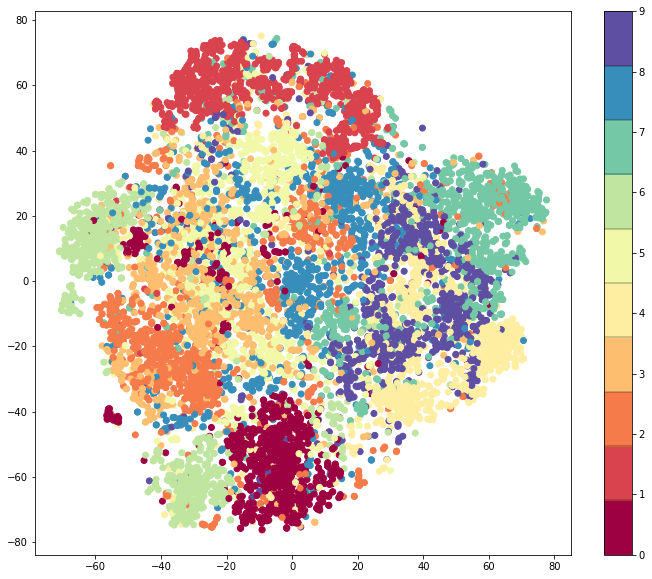

In [9]:
fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)